# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

1. `contract_new.csv` — информация о договоре;
2. `personal_new.csv` — персональные данные клиента;
3. `internet_new.csv` — информация об интернет-услугах;
4. `phone_new.csv` — информация об услугах телефонии.

## Загрузка библиотек

In [1]:
!pip install catboost --quiet
!pip install phik

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import re
import transformers
from tqdm import notebook
from torch.nn.utils.rnn import pad_sequence


from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler, OrdinalEncoder


from collections import namedtuple
import phik
import seaborn as sns
from phik.report import plot_correlation_matrix


from sklearn.compose import(
    make_column_transformer, 
    ColumnTransformer
)

RANDOM_STATE = 201123
TEST_SIZE = 0.25

     |████████████████████████████████| 679 kB 1.3 MB/s eta 0:00:01


## Загрузка данных

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate', 'EndDate'])
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

## Объединение и исследование 

In [3]:
data = (contract
        .merge(personal, on =['customerID'], how='left')
        .merge(internet, on =['customerID'], how='left')
        .merge(phone, on =['customerID'], how='left')
       )

In [4]:
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Необходимо заменить тип данных у колонок EndDate и TotalCharges

In [6]:
data['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
1007.5      4
19.65       4
           ..
4045.1      1
114.45      1
1784.16     1
3013.5      1
198.33      1
Name: TotalCharges, Length: 6658, dtype: int64

Видим 11 пропущенных значений, можем предположить, что это новые абоненты, поэтому заменим значения на 0

In [7]:
# Обработка признака "total_charges"
data.loc[data['TotalCharges'] == ' ', 'TotalCharges'] = 0
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [8]:
data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147
std,30.090047,2112.742814,0.368612
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


In [9]:
data.duplicated().sum()

0

In [10]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Пропущенные значения скорее всего означают, что услуги не подключены, поэтому заменим пропуски на "No"

In [11]:
data = data.fillna('No')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [13]:
data['Target'] = (contract['EndDate'] != 'No').astype(int)

Приведем названия столбцов к нижнему регистру

In [14]:
data.columns = [x.lower() for x in data.columns]

In [15]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [16]:
data['enddate'] = data.loc[data['enddate'] == 'No', 'enddate'] = '2020-02-01'

data['enddate'] = pd.to_datetime(data['enddate'])
data['begindate'] = pd.to_datetime(data['begindate'])

Создадим столбец, в котором будет храниться длительность договора

In [17]:
data['duration'] = (data['enddate'] - data['begindate']).dt.components.days

Чтобы исключить утечку данных, уберём колонки, хранящие даты

In [20]:
data = data.drop(['begindate', 'enddate'], axis=1)

In [21]:
for col in ['paperlessbilling', 'partner', 'dependents', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']:
    data[col] = (data[col] == 'Yes').astype('int64')

In [22]:
data = data.drop('customerid', axis=1)

In [23]:
data.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,duration
0,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0,1,0,0,0,0,0,0,31
1,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1,0,1,0,0,0,0,0,1036
2,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1,1,0,0,0,0,0,0,123
3,One year,0,Bank transfer (automatic),42.30,1960.60,Male,0,0,0,DSL,1,0,1,1,0,0,0,0,1371
4,Month-to-month,1,Electronic check,70.70,353.50,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,0,153


In [24]:
data.columns

Index(['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'target', 'duration'],
      dtype='object')

Распределение значений признака "type":


,count,unique,top,freq
Класс 0,5942,3,Month-to-month,3468
Класс 1,1101,3,Month-to-month,407


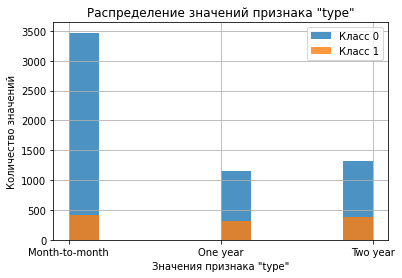

Распределение значений признака "paperlessbilling":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.580613,0.49350,0.0,0.0,1.0,1.0,1.0
Класс 1,1101.0,0.654859,0.47563,0.0,0.0,1.0,1.0,1.0


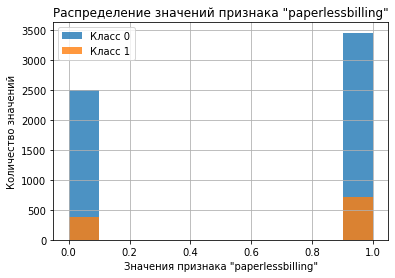

Распределение значений признака "paymentmethod":


,count,unique,top,freq
Класс 0,5942,4,Electronic check,2015
Класс 1,1101,4,Electronic check,350


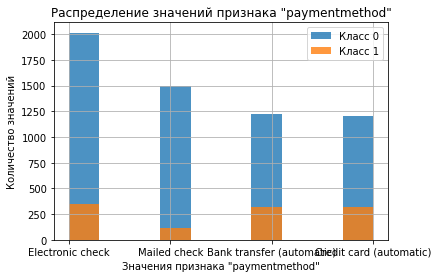

Распределение значений признака "monthlycharges":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
Класс 1,1101.0,75.546004,29.116213,18.40,56.1500,84.2,99.5000,118.75


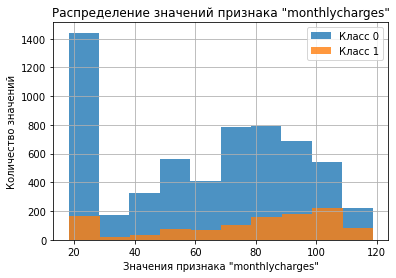

Распределение значений признака "totalcharges":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,2067.866420,2193.898483,0.00,374.3525,1192.80,3173.8375,9221.38
Класс 1,1101.0,2371.377275,1581.862275,77.84,1048.0500,2139.03,3404.9100,7649.76


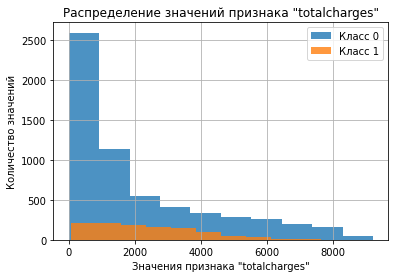

Распределение значений признака "gender":


,count,unique,top,freq
Класс 0,5942,2,Male,2982
Класс 1,1101,2,Male,573


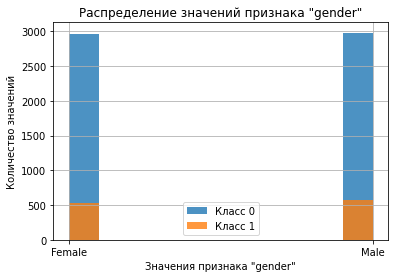

Распределение значений признака "seniorcitizen":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.153147,0.360160,0.0,0.0,0.0,0.0,1.0
Класс 1,1101.0,0.210718,0.408003,0.0,0.0,0.0,0.0,1.0


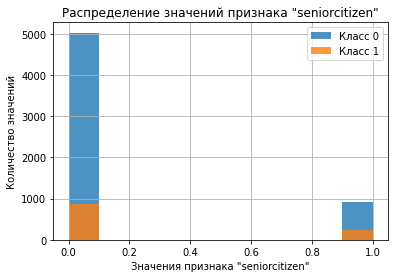

Распределение значений признака "partner":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.451531,0.497687,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.653043,0.476218,0.0,0.0,1.0,1.0,1.0


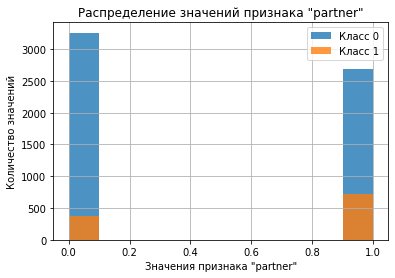

Распределение значений признака "dependents":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.293167,0.455253,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.334242,0.471939,0.0,0.0,0.0,1.0,1.0


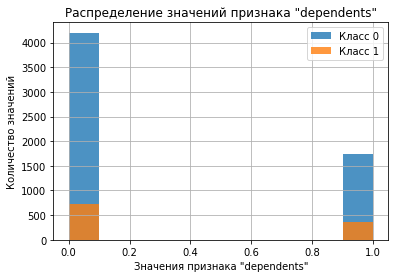

Распределение значений признака "internetservice":


,count,unique,top,freq
Класс 0,5942,3,Fiber optic,2501
Класс 1,1101,3,Fiber optic,595


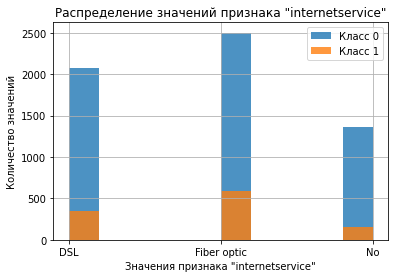

Распределение значений признака "onlinesecurity":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.269943,0.443967,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.376930,0.484837,0.0,0.0,0.0,1.0,1.0


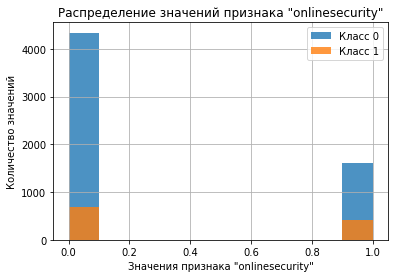

Распределение значений признака "onlinebackup":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.314541,0.464372,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.508629,0.500153,0.0,0.0,1.0,1.0,1.0


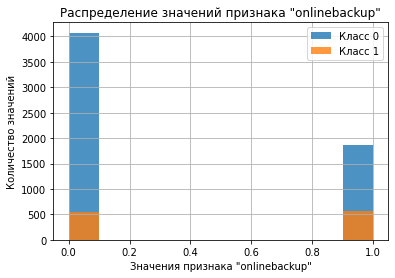

Распределение значений признака "deviceprotection":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.315045,0.464573,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.499546,0.500227,0.0,0.0,0.0,1.0,1.0


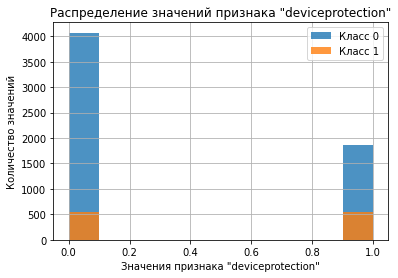

Распределение значений признака "techsupport":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.277011,0.44756,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.361490,0.48065,0.0,0.0,0.0,1.0,1.0


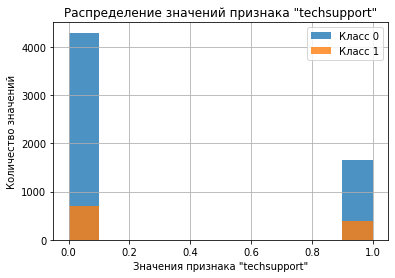

Распределение значений признака "streamingtv":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.357287,0.479241,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.530427,0.499300,0.0,0.0,1.0,1.0,1.0


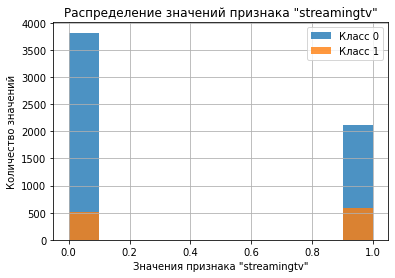

Распределение значений признака "streamingmovies":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.357792,0.479391,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.550409,0.497679,0.0,0.0,1.0,1.0,1.0


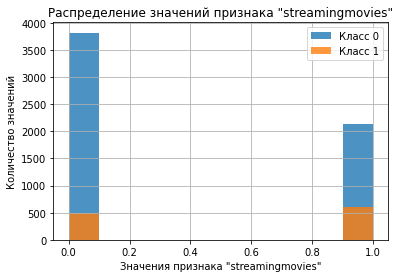

Распределение значений признака "multiplelines":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.385897,0.486847,0.0,0.0,0.0,1.0,1.0
Класс 1,1101.0,0.615804,0.486626,0.0,0.0,1.0,1.0,1.0


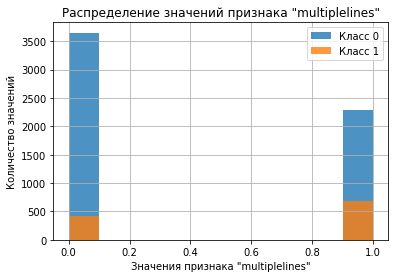

Распределение значений признака "target":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Класс 1,1101.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


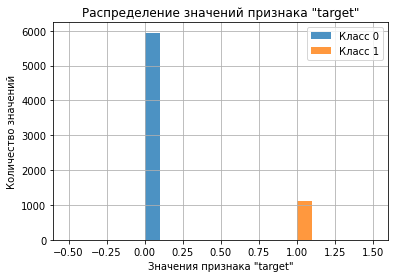

Распределение значений признака "duration":


,count,mean,std,min,25%,50%,75%,max
Класс 0,5942.0,893.681084,716.958551,0.0,245.0,702.0,1523.0,2314.0
Класс 1,1101.0,1615.099001,507.691522,123.0,1279.0,1737.0,2071.0,2253.0


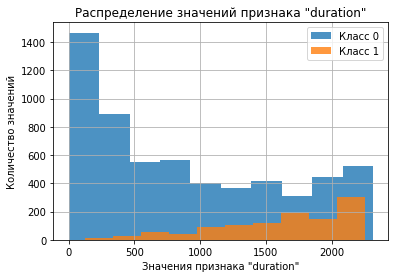

In [25]:
for i in data.columns:
    print(f'Распределение значений признака "{i}":')
                
    t0 = data.loc[data['target'] == 0, i] 
    t1 = data.loc[data['target'] == 1, i] 
                
    t0 = t0.rename('Класс 0') 
    t1 = t1.rename('Класс 1') 
                
    display(pd.DataFrame([t0.describe(), t1.describe()])) 
                
    t0.hist(legend=True, alpha=.8)
    t1.hist(legend=True, alpha=.8) 
    plt.title(f'Распределение значений признака "{i}"')
    plt.xlabel(f'Значения признака "{i}"')
    plt.ylabel('Количество значений')
    plt.show() 


При анализе графиков выявлено, что самый популярный способ оплаты - помесячный и с электронным чеком.
В призанке MonthlyCharges виден пик в районе 20, но при этом большинство пользователей, которые ушли - обладали большими расходами за месяц. Значения в столбце TotalCharges убывают. У признака duration пик приходится на новых пользователей, но видим, что большинство ушедших пользователей пользовались услугами долго.
В признаке gender значения разделились примерно поровну. Большинство пользователей не являются пенсионерами. У большиства абонентов нет детей и жены/мужа.
Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не пользуются популярностью у пользователей

In [26]:
data.phik_matrix()

interval columns not set, guessing: ['paperlessbilling', 'monthlycharges', 'totalcharges', 'seniorcitizen', 'partner', 'dependents', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines', 'target', 'duration']


,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,duration
type,1.000000,0.106860,0.277462,0.388444,0.470860,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.094015,0.665092
paperlessbilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.083398,0.045393
paymentmethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.214832,0.375379
monthlycharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.226280,0.426086
totalcharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.000000,0.135650,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.573191,0.302890,0.799578
gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
seniorcitizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.086159,0.025186
partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.226688,0.497292
dependents,0.147680,0.172593,0.224903,0.184366,0.084247,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.046871,0.205641
internetservice,0.505187,0.231438,0.323886,0.919002,0.490081,0.000000,0.160702,0.000000,0.108463,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.225383,0.056621,0.063783


Видим нулевую зависимость признака gender и очень малую с paperlessbilling, seniorcitizen, internetservice. Самая большая - с totalcharges, что логично, так как чем больше абонент пользуется услугами, тем больше платит.

## Разделение на выборки

In [27]:
target = data['target'] 
features = data.drop(columns='target')

In [28]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
print(features_test.shape)
features_train.shape

(1761, 18)


(5282, 18)

Кодирование данных

In [29]:
encoder = OrdinalEncoder(handle_unknown='ignore')
cat_columns = ['type', 'paymentmethod', 'gender', 'internetservice']

features_train[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test[cat_columns] = encoder.transform(features_test[cat_columns])

/tmp/ipykernel_31/2516940213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[cat_columns] = encoder.fit_transform(features_train[cat_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/2516940213.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Масштабирование данных

In [30]:
scaler = StandardScaler()
num_columns = ['monthlycharges', 'totalcharges', 'duration']
scaler.fit(features_train[num_columns])

features_train[num_columns] = scaler.transform(features_train[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

/tmp/ipykernel_31/1214830706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[num_columns] = scaler.transform(features_train[num_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/1214830706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

## Обучение моделей

### CatBoostClassifier

In [32]:
features_train

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,duration
1844,1.0,0,1.0,0.049156,0.085323,1.0,0,1,0,0.0,1,1,1,0,1,0,0,1.070199
2782,2.0,1,0.0,0.679705,0.629980,1.0,0,1,1,0.0,1,0,1,1,1,1,1,0.201089
4384,0.0,0,0.0,0.490541,-0.817874,0.0,0,1,0,1.0,0,1,1,0,0,0,0,-1.160199
3580,0.0,1,3.0,0.264870,-0.559189,0.0,0,0,1,0.0,0,0,1,1,1,1,0,-0.830724
2394,1.0,1,1.0,0.468969,-0.372594,1.0,0,0,0,1.0,0,1,0,0,0,0,1,1.565089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756,0.0,1,0.0,0.249936,0.052314,1.0,0,0,0,0.0,1,1,1,1,1,0,0,-0.086354
5698,0.0,0,2.0,1.310255,0.223790,1.0,0,1,1,1.0,0,1,1,0,1,1,1,-0.335833
2191,0.0,1,2.0,0.875507,-0.833559,0.0,1,0,0,1.0,0,0,0,0,1,1,0,-1.200875
6161,0.0,0,3.0,0.312991,-0.760433,1.0,0,0,0,1.0,1,0,0,0,0,0,0,-1.076135


In [34]:
%%time
param_grid = {
    'max_depth': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.5],
    'iterations': [200, 400, 500],
    'l2_leaf_reg': [3, 9, 15]
}
estimator = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE)


catboost = GridSearchCV(estimator=estimator,
                        param_grid=param_grid,
                        cv=3,
                        n_jobs=-1,
                        scoring='roc_auc',
                        verbose=10)

catboost.fit(features_train, target_train)


print('AUC-ROC модели CatBoostClassifier составляет:', catboost.best_score_)
print('Лучшие параметры модели', catboost.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3; 1/81] START iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1
[CV 1/3; 1/81] END iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1; total time=   0.8s
[CV 2/3; 1/81] START iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1
[CV 2/3; 1/81] END iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1; total time=   0.7s
[CV 3/3; 1/81] START iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1
[CV 3/3; 1/81] END iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=1; total time=   0.7s
[CV 1/3; 2/81] START iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=3
[CV 1/3; 2/81] END iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=3; total time=   0.8s
[CV 2/3; 2/81] START iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=3
[CV 2/3; 2/81] END iterations=200, l2_leaf_reg=3, learning_rate=0.1, max_depth=3; total time=   1.0s
[CV 3/3; 2/81] STA

### RandomForestClassifier

In [30]:
%%time
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100],
     'class_weight': ['balanced'],
}
rf = RandomForestClassifier(random_state=RANDOM_STATE)


rf = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  cv=3,
                  n_jobs=-1,
                  scoring='roc_auc',
                  verbose=10)
rf.fit(features_train, target_train)

print('AUC-ROC модели RandomForestClassifier составляет:', rf.best_score_)
print('Лучшие параметры модели', rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10
[CV 1/3; 1/36] END class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 2/3; 1/36] START class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10
[CV 2/3; 1/36] END class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 3/3; 1/36] START class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10
[CV 3/3; 1/36] END class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 1/3; 2/36] START class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 1/3; 2/36] END class_weight=balanced, max_depth=5, min_samples_leaf=2, min_samples

## Тестирование лучшей модели

In [33]:
%%time
predictions = catboost.best_estimator_.predict_proba(features_test)[:,1]
print("ROC-AUC модели на тестовой выборке:", roc_auc_score(target_test, predictions))
print('Лучшие параметры модели', catboost.best_params_)

ROC-AUC модели на тестовой выборке: 0.9775986725139268
Лучшие параметры модели {'iterations': 200, 'l2_leaf_reg': 15, 'learning_rate': 0.5, 'max_depth': 3}
CPU times: user 4.6 ms, sys: 34 µs, total: 4.63 ms
Wall time: 3.5 ms


Как можно ещё повысить метрику?

## Важность признаков

In [32]:
importances_df = pd.DataFrame(catboost.best_estimator_.feature_importances_, index=features.columns, columns=['Важность признака'])
importances_df = importances_df.sort_values(by='Важность признака', ascending=False)
importances_df

,Важность признака
totalcharges,37.715388
duration,35.697599
monthlycharges,20.632639
internetservice,1.367808
onlinebackup,0.980658
type,0.594886
multiplelines,0.569629
paymentmethod,0.480163
streamingmovies,0.360390
dependents,0.263594


Анализ важности выявил, что самым важном признаком являестя totalcharges 

## Вывод

1. Необходимые библиотеки и метрики были импортированы, а датасеты объединены. Выяснилось, что им требуется небольшая предобработка, включая выявление целевого признака, отражающего факт ухода клиента. Соответственно, стоит задача классификации. Установлено, что ключевым индикатором для модели является AUC-ROC, превышающий 0.85.
2. Самая большая трудность - доведение метрики качества до показателя 0.85, для повышения метрики было проведено: кодировка признаков, масштабирование, изменение гиперпараметров.
3. Основные этапы: загрузка необходимых инструментов и данных, исследование объединенного датасета и предобработка данных, разделение на выборки и подготовка данных к обучению, обучение моделей, тестирование лучших моделей, определение важности признаков.
4. Лучшая модель - CatBoostClassifier с параметрами 'iterations': 200, 'l2_leaf_reg': 15, 'learning_rate': 0.5, 'max_depth': 3 и значением ROC-AUC = 0.9775986725139268
5. Признаки, по которым обучалась модель: totalcharges, duration, monthlycharges, internetservice, onlinebackup, type, multiplelines, paymentmethod, streamingmovies, dependents, paperlessbilling, deviceprotection, onlinesecurity, gender, streamingtv, seniorcitizen, techsupport, partner	